# **Computer Vision - Assignment 3 - IMAGE REGISTRATION USING HOMOGRAPHIES**
#### Value: 10 (+4) points | Due date: December 22 23:59 | Submission site: https://pradogrado2223.ugr.es/

### Student's Full Name: <mark>Ignacio Garach Vélez</mark>


In this assignment you will learn:

a) How to detect relevant regions using the Harris's algorithm.

b) How to detect matches between images using SIFT descriptors.

c) How to compose a mosaic from a bunch of images. 

## Normas de entrega

Para este trabajo, al igual que para los demás, se deben presentar  las valoraciones y decisiones adoptadas en cada uno de los apartados. También deberá incluirse una valoración sobre la calidad de los resultados obtenidos. Se recuerda que código sin informe explicativo no puntúa.

Para poder evaluar el BONUS se debe obtener al menos el 70% de los puntos de la parte obligatoria

Normas de entrega (EL INCUMPLIMIENTO DE ESTAS NORMAS SIGNIFICA PÉRDIDA DIRECTA DE 1 PUNTO CADA VEZ QUE SE DETECTE UN INCUMPLIMIENTO):

1. El diseño de celdas del documento debe ser respetado.
2. Solo se entregará el código fuente (fichero .ipynb, y ficheros auxiliares externos: P0.py y P1.py) y no se enviarán las imágenes empleadas.
3. Los path que se usen en la lectura de imágenes o cualquier otro fichero de entrada debe ser siempre “/content/drive/My Drive/images/nombre_fichero”
4. El código deberá  presentarse junto con los resultados obtenidos en cada apartado y los  correspondientes comentarios, explicaciones y valoraciones.  Recuerde que la entrega de código sin informe explicativo o valoraciones no puntúa.

The next cell is intended to install an upgrade of the OpenCV package that includes the SIFT algorithm. After the installation, the  python-kernel (restart runtime) has to be restarted to import the new release.

In [1]:
import sys, cv2
from skimage.feature import corner_peaks
(major, minor,_)=cv2.__version__.split(".")
if int(minor) < 5:
  if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call("pip install -U opencv-python".split())

print(cv2.__version__)

4.6.0


This cell sets the environment and imports your packages

In [2]:
# Let's start importing all background modules
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys,os
# change directory
%cd '/content/drive/My Drive'
# Let's import the python module exercises.py  to have access to its functions and Classes
path_to_module='/content/drive/My Drive/CV/'
sys.path.append(os.path.abspath(path_to_module))
import P0,P1
get_image = lambda route: os.path.join('/content/drive/My Drive/images/', route)
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (14,14)

Mounted at /content/drive
/content/drive/My Drive
Mounted at /content/drive


# **Exercise 1:** Harris detector and non-maxima suppresion (3 points)

Write Python code to implement the detection of the strongest 100-150 Harris points in an image, and show your results using the function cv2.drawKeyPoints(). You can apply OpenCV's functions getDerivKernels() and sepFilter2D(). However, those who use their own code from P1 (for computing the derivatives) could have a bonus of +1 point. 

Hint (use different cells for the items):\
a) Fix the derivative and integration scales. Try first sigma values in the range 1-3.\
b) Compute the derivative images. \
c) Compute the three terms of the second moment matrix (SMM) at each pixel. To do it, apply the convolution with a Gaussian mask of size the integration area. \
d) Compute the Harris value at each pixel (discard the points close to the edges).\
e) Apply Non-Maxima Suppression by using the function corner_peaks() from the module skimage.features. The student must set the minimum distace between maxima. The output will be a list of (x,y) coordinates.  Extract the values in these coordinates and create a list of vectors (x,y,value).\
f) Compute the main orientation for each point. This is done by smoothing both derivative images with a sufficiently large sigma (sigma=3) and computing the orientation of the gradient at those points.\
d) Create a list of KeyPoints using the selected points. A KeyPoint is a vector including (x,y,scale,orientation).\
e) Draw the keypoints on the image using the function cv2.drawKeypoints().


En primer lugar vamos a generar una función que genere las derivadas de la imagen a partir de las funciones de la práctica 1.

Procedemos a continuación en HarrisMap a calcular la función de Harris en cada punto:

La idea del detector de Harris es detectar esquinas con alta presencia de 2 "gradientes independientes", para ello calculamos la Second Moment Matrix como un "promedio gaussiano" de las intensidades de los gradientes alrededor de cada punto, siendo más atenuadas aquellas mas alejadas del punto.

$H(u, v) =  \begin{bmatrix}
\sum_W w(x, y) \partial I_x^2 & \sum_W w(x, y) \partial I_x \partial I_y \\
\sum_W w(x, y) \partial I_x \partial I_y & \sum_W w(x, y) \partial I_y^2 
\end{bmatrix}  $

Observemos que en este desarrollo se hacen uso de 2 escalas, la de derivación que define la convolución en el cálculo de las derivadas y la de integración que actua en la atenuación de los gradientes alrededor del punto. Debemos escoger $\sigma$, teniendo en cuenta que una regla que ha demostrado buenos resultados empíricamente es que el de integración sea 1,5 veces el de derivación.

Finalmente calculamos en cada punto la función de Harris como el cociente entre el determinante y la traza:

$f=\frac{determinante(H)}{traza(H)}$, a partir de estos valores se escogerán las esquinas en pasos siguientes.

In [3]:
# Compute image derivatives
def derivatives(im,sigmaD):
  return P1.my2DConv(im, sigmaD, [1, 0]), P1.my2DConv(im, sigmaD, [0, 1])

# Compute Harris-criterium Map
def HarrisMap(dx,dy,sigmaI):
  # Compute the three terms of the SMM at each pixel and he map values
  dx2, dy2, dxdy = dx ** 2, dy ** 2, dx * dy
  mx = P1.my2DConv(dx2, sigmaI, [0, 0])
  my = P1.my2DConv(dy2, sigmaI, [0, 0])
  mxy = P1.my2DConv(dxdy, sigmaI, [0, 0])
  HMap = (mx*my - mxy**2) / (mx+my)
  return HMap

The following cell implements the Non-Maxima-Suppression stage. This function calls the corner_peaks() function from the skimage.feature package (see below). This function returns the local maxima sorted by value.

Esta función efectua la etapa de eliminación de puntos no máximos, necesitamos establecer una distancia mínima entre los puntos detectados, escogeremos 1.0, para no escoger puntos redundantes. Además establecemos un umbral de valor de la función partir del cual considerar los puntos en la detección.

In [4]:
def NonMaximaSuppression(harrisMap, min_distance, threshold):
  points = corner_peaks(harrisMap, min_distance)  # Obtenemos los máximos locales
  values=[]
  coord=[]
  for corner in points:
    cval = harrisMap[corner[0]][corner[1]]        # Obtenemos el valor de cada punto y comparamos con el umbral
    if cval > threshold:
      coord.append(corner)                        # Aceptamos el punto si supera el umbral
      values.append(cval)

  coord = np.array(coord)[np.argsort(values)]     # Ordenamos en función de los valores de Harris
  values = np.array(values)[np.argsort(values)]

  return coord, values

Orientation is computed as the angle of the gradient after smoothing the derivative images with a Gaussian (with sigma=3).

A KeyPoint is an OpenCV's structure, associated to each detected region,  necessary to call OpenCV feature extraction algorithms. You have to create one KeyPoint structure per detected region with information about (location, scale,orientation). (See the OpenCV documentation for more information)

Con los valores obtenidos trás la supresión, debemos generar los KeyPoints de opencv para lo cual necesitamos calcular la orientación de los mismos. La generación es un proceso sencillo y servirá para almacenarlos y poder mostrarlos fácilmente.

In [5]:
# compute the orientation map
def orientation(dx,dy):
  # Let's compute  orientation in degrees
  theta = np.degrees(np.arctan2(P1.my2DConv(dy, 3.0, [0, 0]), P1.my2DConv(dx, 3.0, [0, 0]))) 
  return theta  # Hemos calculado el ángulo y lo hemos transformado a grados

# Create the KeyPoint list from the information about locations, orientations and scale 
# keyPoint=KeyPoint(x_float, y_float, scale_float,orientation_float), in Harris scale=1
# 
def keyPoints(coord,theta):
  keyPoints=[]
  for a in coord:
    deg = theta[a[0], a[1]]
    keyPoints.append(cv2.KeyPoint(x=float(a[1]), y=float(a[0]), size=1.0, angle=deg))
  return(keyPoints)
  

The following cell computes the Harris KeyPoints detection (calling to the previously implemented functions, like derivatives(), HarrisMap(), NonMaximaSuppression(), orientation() and keyPoints()), and displays them on the image. Use the function cv2.drawKeypoints() with flags, cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG+cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS.

En la siguiente celda se realiza el proceso de principio a fin:

*   Lectura de imagen
*   Elección de escalas y umbrales
*   Cálculo de la función de Harris
*   Supresión de puntos no máximos
*   Generación de KeyPoints

Finalmente mostramos la imagen y los puntos con los flags indicados.

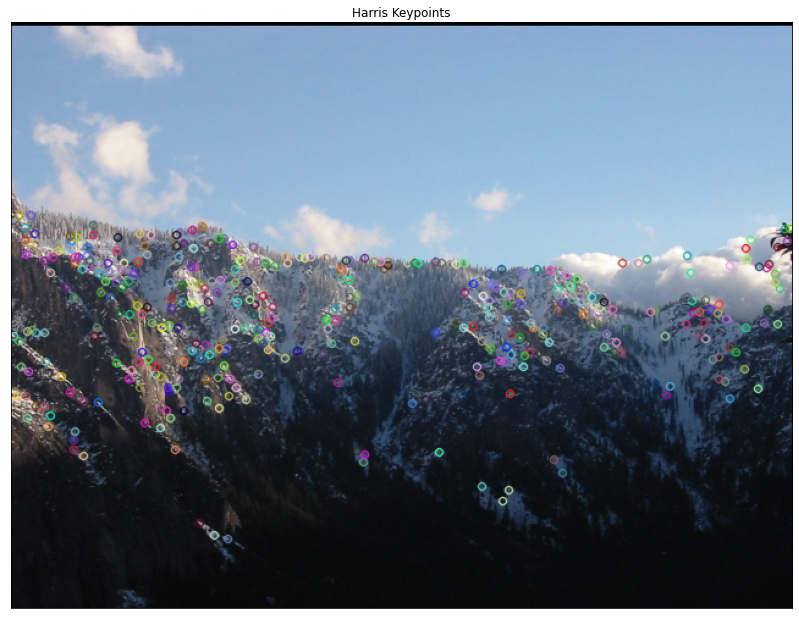

In [6]:
# Let's compute the KeyPoints-Harris and display them
img=P0.readIm(get_image('yosemite7.jpg'),1)
bw=P0.readIm(get_image('yosemite7.jpg'),0)
# parameters
sigmaD=1.5
sigmaI=1.5*sigmaD
sizeIMask=int(6*sigmaI)+1
min_distance=1
Threshold_MINVALUE=300.0  #Se ha escogido el umbral experimentalmente, cuando obtiene un número suficiente de puntos esquina en el releve de la montaña
#
dx, dy = derivatives(bw, sigmaD)
HMap = HarrisMap(dx, dy, sigmaI)
coord, values = NonMaximaSuppression(HMap, min_distance, Threshold_MINVALUE)
theta = orientation(dx, dy)
keypoints=keyPoints(coord, theta)
img=cv2.drawKeypoints(np.uint8(img), keypoints, cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG+cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
P0.displayIm(img, 'Harris Keypoints')

Se observa en los resultados que abundan puntos en los cambios de zonas cielo y tierra o de zonas de cambio de nieve. Esto es debido a que como la información viene de los gradientes, estos son los mayores cambios de intensidad fotométrica que se detectan.

# **Exercise 2:** Matching keypoints between images using SIFT descriptors (2 points)

Write Python code to compute the matching between points from two images. To do so apply the SIFT algorithm to extract points and descriptors in both images.  Use the Force-Brute cross-check criteria and the KNN one to compute matches, and draw the matches between images using the function cv2.drawMatches(). 

En esta primera parte del ejercicio, simplemente se seleccionan los descriptores y los puntos de interés SIFT mediante los métodos de opencv.

In [7]:
# this function computes KeyPoints and descriptors in an image using SIFT
def siftPoints(im,nfeatures=5000):
  sift=cv2.SIFT_create(nfeatures)
  kp, ds = sift.detectAndCompute(np.uint8(im), None)
  return kp,ds

In OpenCV the output of a matching process is a vector of matches. Each match provides information about the indexes of the matched KeyPoints and the distance between them.

La función showKP simplemente llama a la utiidad de mostrar imágenes de la práctica 0, con la imagen resultante de añadir los puntos de interés, con el flag que los muestra con escala y orientación. La función showMatches hace lo propio con los matches.

Por otro lado, la función matching, recibe los descriptores y calcula los matches según el criterio que se le indique, en este caso, los 2 siguientes:



*   Fuerza Bruta: Se relacionan todos los de una imagen con todos los de la otra y hacemos CrossCHECK, hacemos match si l punto más cercano a p_i en la imagen 1 es p_j en la imagen 2, habiendo obtenido previamente las distancias.
*   2-NN Lowe Average: Para cada punto de la primera imagen se encuentran los 2 más cercanos y se acepta el match según el ratio si está suficientemente claro que el primero es mejor que el segundo. Es decir hacemos match si la distancia al primero es menor que 3/4 de la distancia del segundo.

No se ha comentado el código de la siguiente celda, pues es bastante descriptivo de lo que se acaba de explicar.





In [8]:
# This function display the KeyPoints of an image
def showKP(im,kp,title):
  P0.displayIm(cv2.drawKeypoints(np.uint8(im), kp, np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS), title)

# This function display the matches between two images
def showMatches(im1, kp1, im2, kp2, matches, N, title='Matches'):
  if N:
    img = cv2.drawMatches(np.uint8(im1), kp1, np.uint8(im2), kp2, matches, np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  else:
    img = cv2.drawMatchesKnn(np.uint8(im1), kp1, np.uint8(im2), kp2, matches, np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  return P0.displayIm(img, title)

#This function compute matches between descriptors of two images
def matching(ds1,ds2,FlagMode='BF'):
  if FlagMode=='BF':
    bf=cv2.BFMatcher(crossCheck=True, normType=cv2.NORM_L2)
    # Match descriptors.
    matches = bf.match(ds1, ds2)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    return matches
  elif FlagMode=='KNN':
    bf = cv2.BFMatcher(crossCheck=False, normType=cv2.NORM_L2)
    matches = bf.knnMatch(ds1, ds2, k=2)    #Se fija el número de vecinos a 2 
    # Apply ratio test
    bestms=[]
    for m,n in matches:
      if m.distance < 0.75*n.distance:
          bestms.append(m)
    return bestms
  else:
    return print('Error in Matching mode')
  

Now check your functions about KeyPoints and matching. To do so, read two consecutive images, let say Yosemite1 and Yosemite2, and show and analyze the results obtained.

A continuación probamos los métodos con dos imágenes solapadas de Yosemite, compararemos los resultados obtenidos con Fuerza Bruta y 2-NN:

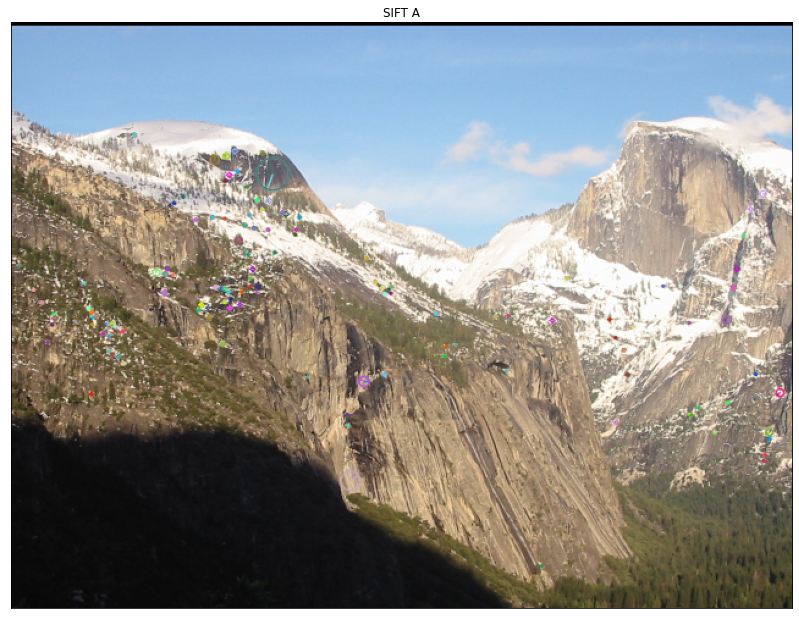

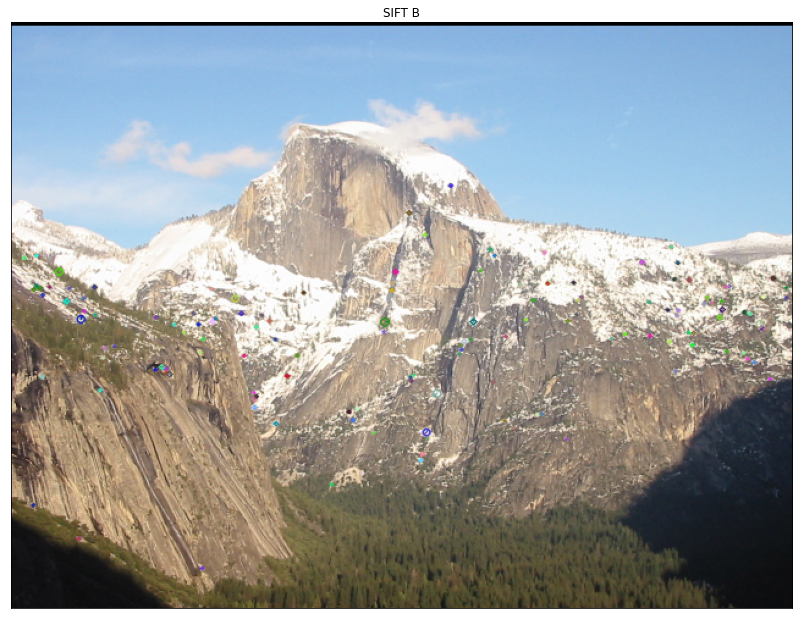

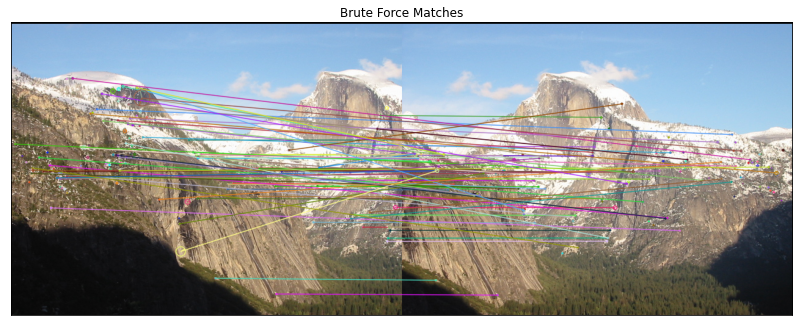

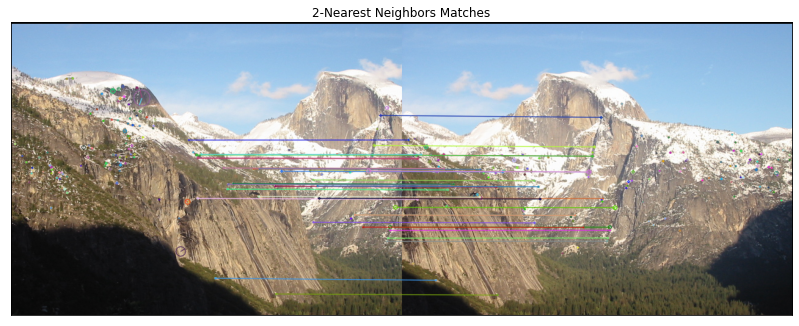

In [9]:
# Here we check our functions 
img1=P0.readIm(get_image('yosemite1.jpg'),1)
im1=cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
img2=P0.readIm(get_image('yosemite2.jpg'),1)
im2=cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
# let's compute points and descriptors
kpa, dsa= siftPoints(im1, 200)
kpb, dsb = siftPoints(im2, 200)
showKP(img1, kpa, 'SIFT A')
showKP(img2, kpb, 'SIFT B')

matchesBF=matching(dsa, dsb, 'BF')
showMatches(img1, kpa, img2, kpb, matchesBF, True, title="Brute Force Matches")
matchesKNN=matching(dsa, dsb, 'KNN')
showMatches(img1, kpa, img2, kpb, matchesKNN, True, title="2-Nearest Neighbors Matches")

La calidad de fuerza bruta es baja, se obtienen muchos matches pero la alta cantidad de diagonales indica la presencia de muchos errores, además hay bastantes matches entre zonas de la montaña que no aparecen en la segunda imagen y viceversa.

En cuanto al algoritmo 2-NN de Lowe, se obtienen menos matches, pero casi todos ellos parecen muy razonables y se encuentran en la zona que comparten ambas imágenes, es evidente que el criterio de comparación con el segundo mejor punto hace muy robusto el algoritmo, aún así quizá podría relajarse un poco el ratio para obtener más matches.

# **Exercise 3.A:** Homographies calculation (1 point)

Now you are ready to calculate the homographies. To calculate the homography between two images call the function cv2.findHomography(), which takes as input the lists of located KeyPoints (in both images) and the matches found between them. Use RANSAC to perform a robust estimation.

En esta función, se llama al cálculo de la homografía de opencv para que haga el ajuste de parámetros utilizando Ransac, porque se asume que va a haber matches erróneos y el uso de Ransac, hace ajustes en conjuntos de 4 matches para quedarse con un ajuste de los inliers evitando que se estropee por el error cuadrático de los matches erróneos.

In [10]:
# this function computes a homography
def homography(kp1,kp2,matches, Ransac_Error,MIN_MATCH_COUNT=20):
  # the order is important
  if len(matches)>MIN_MATCH_COUNT:
    # Let's extract  two lists of points in correspondences from matches
    src_pts=[]
    dst_pts=[]
    for m in matches:
      src_pts.append(kp1[m.queryIdx].pt)  #Extraemos los puntos en correspondencia del dominio y el codominio
      dst_pts.append(kp2[m.trainIdx].pt)
    src_pts=np.array(src_pts)
    dst_pts=np.array(dst_pts)
    # before changing parameter values, try first the opencv by default.
    H, mask = cv2.findHomography(src_pts, dst_pts, Ransac_Error)  #Llamamos a opencv para que ajuste una homografía por mínimos cuadrados mediante el algoritmo RANSAC para evitar matches incorrectos
    print('Inliers:', sum(mask))
  else:
     print('Error - very few matches')
  return H

# **Exercise 3.B:** Building a mosaic (4 points)


To compose a mosaic we will need to set several pieces of information. \
a) The size of the canvas according to the number of images to be stitched and their dimensions.\
b) The central image that will give the axes to the mosaic.\
c) The order of each image with respect to the central one.\
d) The homography to copy the central image into the canvas.

Here is the guideline to compute a lineal Mosaic:\
a) Read the images in the order left-right of the camera.\
b) Set one central image as the reference to give axes to the canvas.\
c) Compute the homography between each two consecutive images in your list.\
d) Set the canvas and the reference homography.\
e) Compute the homography between each image and the canvas.\
f) Use  the function cv2.warpPerspective() to transport the images to the canvas using the computed homographies.\
g) Remove redundant black-pixels.



Para la construcción del mosaico, implementamos varias funciones auxiliares, la función computeLocalHomographies que para cada par de imágenes solapadas calcula los puntos de interés y la homografía entre ellos con la función del ejercicio anterior.

La siguiente función calcula la homografía hacia el mosaico para lo que necesita invertirlas.

La última, define la homografía de la imagen central inicial para la construcción del mosaico.

In [11]:
# this function computes the homographies between each two consecutive images
def computeLocalHomographies(images):
  H=[]
  Ransac_Error=cv2.RANSAC
  siftd = cv2.SIFT_create(128)
  for item in range(0,len(images)-1):
    kp1,ds1=siftd.detectAndCompute(np.uint8(images[item]), None)
    kp2,ds2=siftd.detectAndCompute(np.uint8(images[item+1]), None)
    matches=matching(ds1, ds2)                                          # Calculamos los matches a partir de los descriptores obtenidos
    Haux=homography(kp1, kp2, matches, Ransac_Error, MIN_MATCH_COUNT=20)# Llamamos al cálculo de la homografía anteriormente definida 
    H.append(Haux)
    print(Haux)
  return H

# this function computes the homography from each image to the canvas
def mosaicHomographies(H,idx,ni):
  # idx is the index of the reference image
  # invert homographies
  for item in range(idx,len(H)):
    H[item] = inv(H[item])
  # compute homographies by compositoon
  for item in range(idx-2,-1,-1):       #Hacia atrás
    H[item] = np.dot(H[item+1], H[item])
  for item in range(idx+1,ni-1,1):#Hacia adelante
    H[item] = np.dot(H[item-1], H[item])
  return H

# this function fixes the homography from the central image to the canvas
# others definitions are possible
def axesHomography(nim,sizeim,sizecanvas):
  H=np.eye(3)                                                           #Genera la identidad de orden 3
  H[0,2]=sizecanvas[1]//2-sizeim[1]//2                                  #Ajustamos en función del tamaño de imagen y del canvas
  H[1,2]=sizecanvas[0]//2-sizeim[0]//2
  return H

Las siguientes funciones auxiliares generan el canvas en función de los canales de la imagen (monobanda o tribanda) y del tamaño, y limpian los bordes negros resultantes del cosido del mosaico.

Finalmente composeMosaic monta el mosaico final a partir de las imágenes y las homografías calculadas con el resto de funciones.

Para ello se hace uso de la función de opencv warpPerspective:
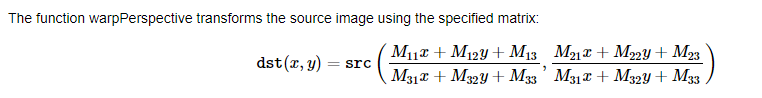

In [12]:
# Auxiliary functions
# this function defines and return the canvas
def setCanvas(row,col,flagColor,nim=2):
  cols=col*nim
  rows=row*nim  #Estimación muy exagerada del tamaño de canvas necesario
  if flagColor==3:
    return np.zeros((rows,cols,3),dtype=np.uint8)
  else:
    return np.zeros((rows,cols),dtype=np.uint8)

# This function removes the redundant black-pixels from the canvas
def blackOut(img):
  if len(img.shape)==3:
    im =cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    mask = np.array((im > 0), np.uint8) 
    x,y,w,h=cv2.boundingRect(mask)
    return img[y:y+h,x:x+w,:]
  else:
    mask = np.array((img > 0), np.uint8) 
    x,y,w,h=cv2.boundingRect(mask)
    return img[y:y+h,x:x+w]
  
# this function composes the mosaic from the extremes to the center
# transporting each image with its homography
def composeMosaic(images,canvas,H,idxc,H0,flagAffinity):
  rows=canvas.shape[0]
  cols=canvas.shape[1]
  nH=0
  # global composition
  for nim in range(0,idxc):
    if nim == idxc:                   #Separamos el caso de la imagen central
      print('nim=',nim,'nH=',0)
      Haux=H0
    else:
      print('nim=',nim,'nH=',nH)
      Haux= np.dot(H0, H[nH])             
      nH=nH+1
    print(Haux/Haux[2,2])             #En la siguiente línea añadimos la imagen con la homografía aplicada al canvas con border transparent para que no solape las imágenes añadidas con anterioridad
    canvas=cv2.warpPerspective(images[nim], Haux, [cols, rows], dst=canvas, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
  nH=len(H)-1

  for nim in range(len(images)-1,idxc-1,-1):
    if nim == idxc:              
      print('nim=',nim,'nH=',0)
      Haux=H0
    else:
      print('nim=',nim,'nH=',nH)
      Haux= np.dot(H0, H[nH]) 
      nH=nH-1
    print(Haux/Haux[2,2])
    canvas=cv2.warpPerspective(images[nim], Haux, [cols, rows], dst=canvas, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
  return canvas


The next cell contains the mosaic catalog with 5 possible scenarios: 

- EXAMPLE 1 (rectangular projection with 4 Yosemite images) (2 points)

- EXAMPLE 2 (rectangular projection with 8 corridor images) (3 points)

- EXAMPLE 3 (rectangular projection with 10 office images) (4 points)

- EXAMPLE 4 (14 images of Granada/Alhambra, mainly for spherical projection; see Bonus)

- EXAMPLE 5 (14 images of Sierra Nevada, mainly for spherical projection; see Bonus)

In [13]:
# CATALOG OF MOSAIC

# Mosaic construction: All of them are Left-Right camera motion

mosaicIndex=3
images = []

#EXAMPLE:1 (easy, for rectangular projection) (2 points)
if mosaicIndex==1: 
  PREFIX=''
  nameImages=['yosemite1.jpg','yosemite2.jpg','yosemite3.jpg','yosemite4.jpg']
  for item in nameImages:
    images.append(P0.readIm(get_image(PREFIX+item)))
  
# EXAMPLE-2 (rectangular projection, tricky in a couple of homographies) (3 points)
elif mosaicIndex==2:
  PREFIX='corridor/'
  nameImages=['Picture1.jpg','Picture2.jpg','Picture3.jpg','Picture4.jpg','Picture5.jpg','Picture6.jpg','Picture7.jpg','Picture8.jpg']
  for item in nameImages:
    images.append(P0.readIm(get_image(PREFIX+item)))

# EXAMPLE-3 (rectangular projection) (4 points)
elif mosaicIndex==3:
    PREFIX='despacho/'
    nameImages=['mosaico002.jpg','mosaico003.jpg','mosaico004.jpg','mosaico005.jpg','mosaico006.jpg',
            'mosaico007.jpg','mosaico008.jpg','mosaico009.jpg','mosaico010.jpg','mosaico011.jpg']
    for item in nameImages:
      images.append(P0.readIm(get_image(PREFIX+item)))

# EXAMPLE-4 (mainly for spherical projection)
elif mosaicIndex==4:
  PREFIX='Granada/IMG_20211030_1104'
  nameImages=['10_S.jpg','13_S.jpg','15_S.jpg','17_S.jpg','18_S.jpg','20_S.jpg',
            '21_S.jpg', '25_S.jpg','26_S.jpg', '28_S.jpg','31_S.jpg','33_S.jpg',
            '34_S.jpg','36_S.jpg']
  for item in nameImages:
    images.append(P0.readIm(get_image(PREFIX+item)))


# EXAMPLE-5 (mainly for spherical projection)
elif mosaicIndex==6:
    PREFIX='SierraNevada/IMG_20220312_1029'
    nameImages=['31_S.jpg','32_S.jpg','34_S.jpg','37_S.jpg','40_S.jpg','42_S.jpg',
            '44_S.jpg','46_S.jpg','48_S.jpg','50_S.jpg','51_S.jpg','54_S.jpg',
            '57_S.jpg','58_S.jpg'] 
    for item in nameImages:
      images.append(P0.readIm(get_image(PREFIX+item)))
else:
    print('Error - no such Mosaic')

Rectangular projection: The target is example-3. Example 1 and 2 are also possible but you get a lower mark (see the mosaic catalog). You must use all images.

Montamos el mosaico del exterior de la ETSIIT con proyección rectangular, escogiendo la imagen central en la lista.

In [14]:
from numpy.linalg import inv
flagSpherical=False  # 
if flagSpherical:
  images=SphericalProjection(images)
print('read images',len(images))
# Set the central image 
idxc=int(len(images)/2)
print('idxc',idxc)
# Compute local homographies beetwen images
H=computeLocalHomographies(images)
# Set the canvas
canvas=setCanvas(images[idxc].shape[0], images[idxc].shape[1], len(images[idxc].shape), len(images))
# Compute the homography given axis to the canvas
H0=axesHomography(len(images), images[idxc].shape, canvas.shape)
# Compute the homographies between images and the canvas
H=mosaicHomographies(H, idxc, len(images))
# Compose the mosaic transporting the images into the canvas
mosaic= composeMosaic(images, canvas, H, idxc, H0, None)


read images 10
idxc 5
Inliers: [47]
[[ 1.05608529e+00  1.02869210e-02 -7.42389885e+01]
 [ 1.32813342e-02  1.03543388e+00 -8.59611432e-01]
 [ 1.57301678e-04  1.16159306e-05  1.00000000e+00]]
Inliers: [50]
[[ 1.04920709e+00  7.64788348e-03 -6.52029851e+01]
 [ 1.06131349e-02  1.02779249e+00 -4.34016062e-02]
 [ 1.38537611e-04  9.27954368e-07  1.00000000e+00]]
Inliers: [68]
[[ 1.05193895e+00  8.09815426e-03 -7.25753399e+01]
 [ 1.19063146e-02  1.02679038e+00  9.46046056e-02]
 [ 1.54899425e-04 -1.34227016e-05  1.00000000e+00]]
Inliers: [59]
[[ 9.81159970e-01 -2.62748248e-03  2.92598575e+01]
 [-4.69906971e-03  9.93565022e-01 -3.67744073e-01]
 [-5.87579424e-05  1.29975732e-05  1.00000000e+00]]
Inliers: [38]
[[ 1.07904075e+00  9.80174231e-03 -1.11736851e+02]
 [ 1.82482062e-02  1.04606919e+00 -6.68866022e-01]
 [ 2.36476245e-04 -2.26878208e-05  1.00000000e+00]]
Inliers: [64]
[[ 1.05572209e+00  6.61916871e-03 -7.04925138e+01]
 [ 1.36592477e-02  1.03118622e+00 -3.62794781e-01]
 [ 1.62396713e-04 -6.8

En las siguientes celdas mostramos las imágenes de partida y el resultado que podemos valorar como bastante bueno sin detectarse distorsiones graves y componiendose muy bien todas las imágenes de las zonas que aparecen. Evidentemente la imagen no es rectangular pues se producen distorsiones por la perspectiva como se ve en la parte superior. Por otro lado hay hueco en la zona inferior izquierda porque faltan fotos de esa zona.

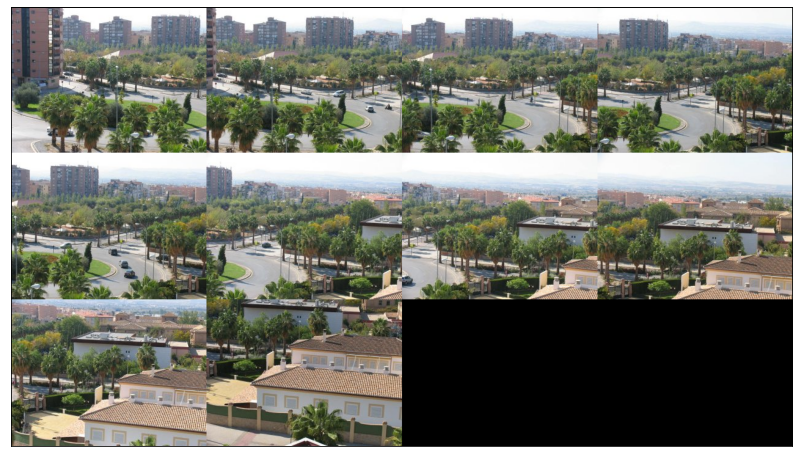

In [15]:
P0.displayMI_ES(images)

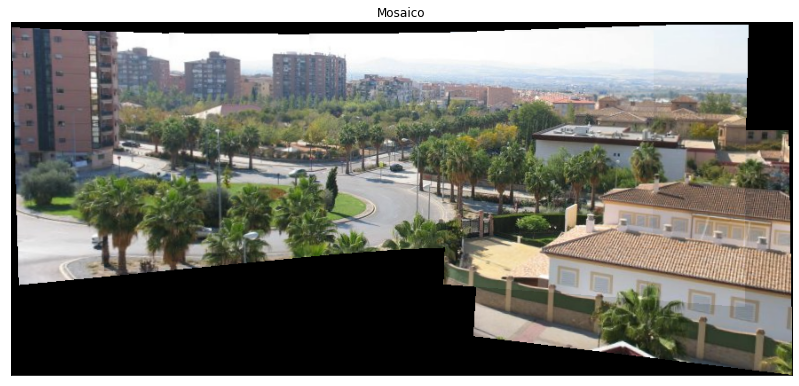

In [16]:
P0.displayIm(blackOut(mosaic),'Mosaico')

# **BONUS**: Spherical projection.  (3 points)
Use Examples 4 or 5's images and show the case f=500. You must use all images.

En primer lugar, debemos calcular las coordenadas esféricas con las que se corresponden las coordenadas habituales, para ellos seguimos las siguientes ecuaciones tomadas del libro de Szeliski:

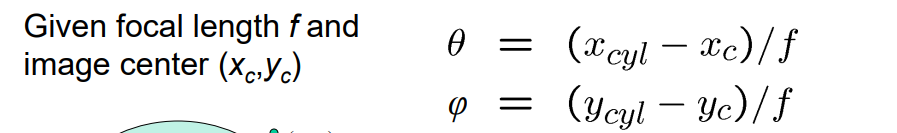

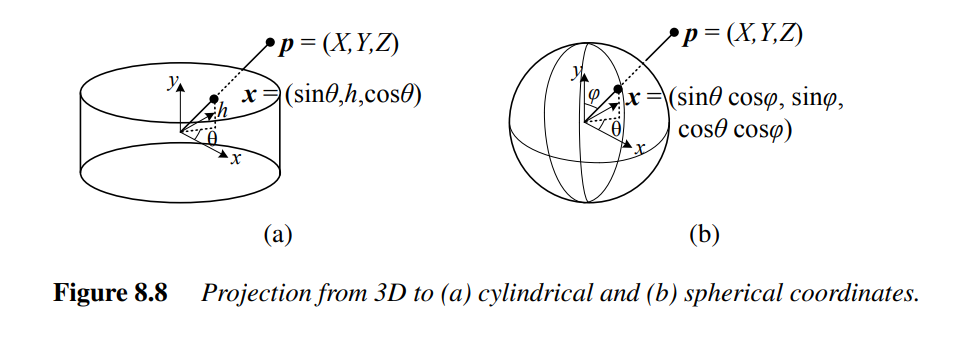

In [17]:
def spherical_lookupTable(f,imsize):
  # Here we compute the spherical coordinates where the image pixel project.
  # A sphere of radius r=f is fixed.
  # Begin by discretizing the azimuth and elevation ranges according to the image size and the focal length fixed. 
  # Then compute the coordinates on the sphere for each couple of angle-values ( azimuth and elevation)
  # return the computed coordinates
  # Slides and Szeliski's book equations will help
  w = imsize[0]
  h = imsize[1]
  x_c = w/2
  y_c = h/2

  xs, ys = np.meshgrid(np.linspace(0, w, num=w), np.linspace(0, h, num=h)) # Hacemos un muestreo de puntos del espacio donde se proyectará para calcular los ángulos(todos los píxeles)
  
  theta = (xs-x_c)/f
  phi = (ys-y_c)/f

  xs = np.sin(theta) * np.cos(phi)
  ys = np.sin(phi)
  zs = np.cos(theta) * np.cos(phi)

  x = f*xs/zs+x_c
  y = f*ys/zs+y_c 

  return x.astype(np.float32), y.astype(np.float32)
  

def sphericalTrim(images,cutPix):                                          # Eliminamos bordes sobrantes a los lados
  # here we eliminate by left and right, above and below each image the number the
  # lines indicates in cutPix=[#row,#column]
  l = np.linspace(0, cutPix[0]).astype(int)
  r = -l
  a = np.linspace(0, cutPix[1]).astype(int)
  b = -a
  for i in range(len(images)):
    images[i] = np.delete(images[i], l, axis=0)
    images[i] = np.delete(images[i], r, axis=0)
    images[i] = np.delete(images[i], a, axis=1)
    images[i] = np.delete(images[i], b, axis=1)
  return images


def sphericalProjection(images,f,cutpix):
  # Here we interpolate a rectangular mesh of values from the  projection of the pixels.  #LLamamos al cálculo de coordenadas con la distancia focal y el corte de píxeles sobrantes
  # images: set of images; f: focal length; cutpix: #row and #column to remove

  sphim=[]

  for im in images:
    x, y = spherical_lookupTable(f, im.shape)
    sphim.append(cv2.remap(im, x, y, interpolation=cv2.INTER_CUBIC))    #Obtenemos las imágenes proyectadas, interpolando en los huecos con interpolación con splines cúbicos de opencv

  # after projection images must be trimmed
  sphim=sphericalTrim(sphim, cutpix)
  return sphim  # vector of projected images

Definimos una función que haga todas las llamadas directamente, con el trim a realizar y la distancia focal.

In [18]:
def SphericalProjection(images):
  return sphericalProjection(images, 500, [10, 10])

Probamos el resultado con las imágenes de Granada capital y de la Alhambra, el procedimiento de cosido y de obtención de homografías es el mismo una vez calculadas las coordenadas esféricas.

In [19]:
images2=[]
mosaicIndex=4
if mosaicIndex==4:
  PREFIX='Granada/IMG_20211030_1104'
  nameImages=['10_S.jpg','13_S.jpg','15_S.jpg','17_S.jpg','18_S.jpg','20_S.jpg',
            '21_S.jpg', '25_S.jpg','26_S.jpg', '28_S.jpg','31_S.jpg','33_S.jpg',
            '34_S.jpg','36_S.jpg']
  for item in nameImages:
    images2.append(P0.readIm(get_image(PREFIX+item)))
from numpy.linalg import inv
 # HERE CONSIDER A SPHERICAL PROJECTION
flagSpherical=True
if flagSpherical:
  images2=SphericalProjection(images2)
print('read images',len(images2))
# Set the central image 
idxc=int(len(images2)/2)-1    # Se ha escogido la anterior al centro pues el resultado es mejor(más inliers en algunas homografías)
print('idxc',idxc)
# Compute local homographies beetwen images
H=computeLocalHomographies(images2)
# Set the canvas
canvas=setCanvas(images2[idxc].shape[0], images2[idxc].shape[1], len(images2[idxc].shape), len(images2))
# Compute the homography given axis to the canvas
H0=axesHomography(len(images2), images2[idxc].shape, canvas.shape)
# Compute the homographies between images and the canvas
H=mosaicHomographies(H, idxc, len(images2))
# Compose the mosaic transporting the images into the canvas
mosaic2= composeMosaic(images2, canvas, H, idxc, H0, None)

read images 14
idxc 6
Inliers: [14]
[[ 1.01575284e+00 -1.31491924e-02 -1.48826335e+02]
 [-8.53373441e-03  9.94540554e-01  1.74895496e+01]
 [-9.72577367e-05 -2.90262864e-05  1.00000000e+00]]
Inliers: [37]
[[ 9.38685297e-01  5.30444098e-03 -1.02694214e+02]
 [-6.04752392e-02  9.52902871e-01  4.56362739e+00]
 [-2.53187184e-04  1.23698136e-05  1.00000000e+00]]
Inliers: [20]
[[ 9.40828077e-01  1.05028708e-03 -1.18593965e+02]
 [-7.00950701e-02  9.49162731e-01  1.26460469e+01]
 [-3.13075315e-04  7.70386898e-06  1.00000000e+00]]
Inliers: [32]
[[ 9.60817959e-01  3.71556127e-02 -1.14217680e+02]
 [-9.13919209e-02  9.76169872e-01  2.90598468e+01]
 [-2.50561994e-04  4.03618541e-05  1.00000000e+00]]
Inliers: [17]
[[ 9.39355632e-01 -1.07797016e-02 -7.56114801e+01]
 [-4.43394474e-02  9.52510261e-01 -3.54405566e+00]
 [-2.37161356e-04  3.39359861e-06  1.00000000e+00]]
Inliers: [29]
[[ 9.49047374e-01  2.16964500e-02 -1.09886790e+02]
 [-7.40687950e-02  9.67508265e-01  2.53406354e+01]
 [-2.65708094e-04  1.0

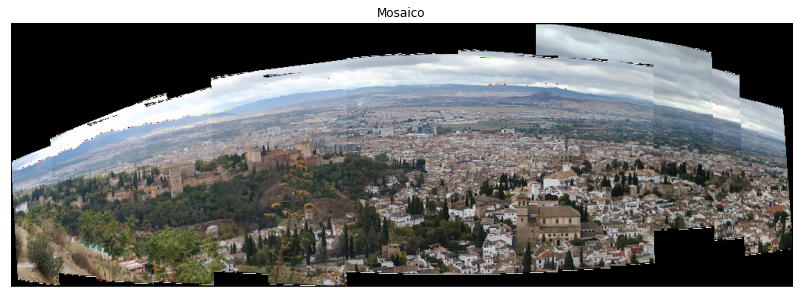

In [20]:
P0.displayIm(blackOut(mosaic2),'Mosaico')


El resultado es razonablemente bueno, si bien parece haber algunas descoordinaciones en el cosido, esto ocurre especialmente entre las imágenes que Ransac obtuvo pocos Inliers en la celda anterior. Además puede que este ocurriendo algún problema en la interpolación que no he sabido detectar pues aparecen algunos píxeles rojos y azules en algunas zonas.